<a href="https://colab.research.google.com/github/statscol/Embeddings-end-to-end/blob/main/Embeddings-classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf 
import seaborn as sns
import matplotlib.pyplot as plt


### Sentiment Analysis
We want to predict the polarity of a user review using its raw text. 



In [ ]:
reviews=pd.read_csv("challenge_data.csv")
reviews.head()

,Unnamed: 0,text,tag
0,0,"in exotica everybody is watching , and what is...",pos
1,1,some of the gags are so carefully innocuous th...,neg
2,2,press junkets are a haven for control freaks .,neg
3,3,"then i realized he was , and i was watching it .",neg
4,4,uh huh .,neg


## Data Wrangling
let's clean data and change pos and neg labels to integers

In [ ]:
##check whether or not we have null values

np.sum(reviews.isnull(),axis=0)

Unnamed: 0     0
text          17
tag            8
dtype: int64

In [ ]:
## for now lets get rid of those reviews which do not have a tag available and fill null reviews with "" 

reviews=reviews[~reviews.tag.isna()]
reviews.text.fillna("",inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
#check out dataset
np.sum(reviews.isnull(),axis=0)

Unnamed: 0    0
text          0
tag           0
dtype: int64

In [ ]:
reviews['label']=reviews['tag'].apply(lambda k: 0 if k=='neg' else 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## EDA

Positive reviews are far less than negative ones, this will be a problem when training a model given that performance metric are sentitive to class imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


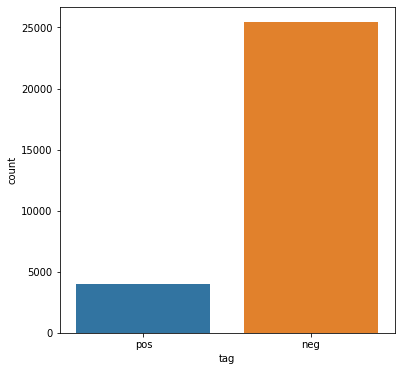

In [ ]:
f,ax=plt.subplots(figsize=(6,6))
sns.countplot("tag",data=reviews,ax=ax);

In [ ]:
### use external data 

##what if we include external reviews to increase minority class?
##lets use Imdb data and keras data api to get data
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=50000, seed=123)


for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['text', 'label']
train['text'] = train['text'].str.decode("utf-8")
##we're only interested in positive comments
positive_external=train[train['label']==1]

###include external data
reviews=pd.concat([reviews[['text','label']],positive_external])


Found 75000 files belonging to 3 classes.


In [ ]:
##remove special characters and use lowerCase only

import re

def remove_special(str1):
  str_aux= str1.replace('<br>', "")
  str_aux= str_aux.replace('</br>', "")
  str_aux=re.sub(r"[^a-zA-Z0-9]"," ",str_aux).lower()
  str_aux=re.sub('\s+', ' ',str_aux).strip()
  return str_aux

reviews['text']=reviews['text'].apply(lambda d: remove_special(d))


In [ ]:
print( "Majority to minority class relation : " , np.round(sum(reviews.label==0)/sum(reviews.label==1),1))

Majority to minority class relation :  2.1



# Approach No.1

Using Pre trained embeddings Glove as base embeddings to build a classifier

In [ ]:

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization 

##lets consider 1000 words at max and every review's representation up to 200 words

vectorizer = TextVectorization(max_tokens=1000, output_sequence_length=200)
text_vect = tf.data.Dataset.from_tensor_slices(reviews.text)
vectorizer.adapt(text_vect)



##get a dictionary for every word in the vocabulary and it's integer value 
vocab = vectorizer.get_vocabulary()
word_index = dict(zip(vocab, range(len(vocab))))



In [ ]:
##take randomly 10 % of negative cases out to balance dataset
neg_rev=reviews[reviews['label']==0].sample(frac=0.9)
pos_rev=reviews[reviews['label']==1]
reviews=pd.concat([neg_rev,pos_rev]).sample(frac=1)


In [ ]:
##apply vectorizer and tokenization to every review text and divide data on train-test 80%-20%

from sklearn.model_selection import train_test_split

reviews_tk = vectorizer(np.array([[k] for k in reviews.text])).numpy()
labels=reviews.label.values.astype('int64')

X_train,X_test,Y_train,Y_test = train_test_split(reviews_tk,reviews.label.values, test_size=0.2, random_state=123,stratify=labels)
print("Reviews for training: {} \nReviews for testing: {}".format(X_train.shape[0],X_test.shape[0]))

Reviews for training: 30186 
Reviews for testing: 7547


## Using Stanford GloVe Embeddings 


In [ ]:
### get GloVe embeddings 
%cd /content
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

/content
--2021-09-08 13:43:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-08 13:43:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-08 13:44:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

In [ ]:
##get word embeddings into a matrix
##glove has an embeddings vector of size 100 for every word
glove_path = "/content/glove.6B.100d.txt"

embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs


num_tokens = len(vocab) + 2
embedding_dim = coefs.shape[0] ## embeddings size
words_found = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        words_found+= 1
    
print("{:.2%} words of vocab in GloVe embeddings".format(words_found/len(vocab)))


99.80% words of vocab in GloVe embeddings


## Define & train the model

We'll be using Keras functional API to train a classifier. Callbacks to avoid overfitting are also provided in the process

In [ ]:
Y_train=Y_train.astype('int64')
Y_test=Y_test.astype('int64')

In [ ]:
##define class weights for imbalanced data
n_classes=np.unique(Y_train).shape[0]
neg_weight = (1 / sum(Y_train==0)) * (Y_train.shape[0] / n_classes)  ##according to TF, scale by number of classes
pos_weight = (1 / sum(Y_train==1)) * (Y_train.shape[0] / n_classes)

class_weight = {0: neg_weight, 1: pos_weight}
print(class_weight)

{0: 0.741780115004669, 1: 1.5339973574550259}


In [ ]:
from tensorflow.keras.layers import Embedding,Input,Dense,Flatten,MaxPooling1D,Conv1D,Dropout,GlobalMaxPool1D,GlobalMaxPooling1D,BatchNormalization,AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1,l2


# embedding_layer = Embedding(
#     num_tokens,
#     embedding_dim,

# )

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, ##avoid training pre-defined embeddings
)



int_sequences_input =Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = Conv1D(64, 5, activation="linear",kernel_regularizer=l2(0.005))(embedded_sequences) #regularization L2 to perform weight decay, helps avoid overfitting ( docs suggest values ranging from 0 to 0.1)
x = Conv1D(32, 5, activation="relu",kernel_regularizer=l2(0.001))(embedded_sequences)
x = MaxPooling1D(5)(x)
x= GlobalMaxPool1D()(x)
x = Dropout(0.3)(x)
x = Dense(32, activation="relu",kernel_regularizer=l2(0.005))(x)
x = Dropout(0.3)(x)
x=Dense(1, activation="sigmoid")(x)

model=Model(int_sequences_input,x,name="predictor_polarity")


model.summary()

Model: "predictor_polarity"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         100200    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 32)         

In [ ]:
##lets define a callback to avoid overtraining when validation error stucks at some point
patience_call=5
metric=tf.keras.metrics.AUC()

cb_f = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience_call,restore_best_weights=True) #set the best weights found at scoring on validation set
opt = Adam(learning_rate=1e-4)
model.compile(
    loss="binary_crossentropy", optimizer=opt, metrics=[metric]
)
check = tf.keras.callbacks.ModelCheckpoint('/content',
                                           monitor='val_loss', 
                                           save_best_only=True,
                                           mode='max',
                                           patience=patience_call)

history=model.fit(x=X_train,y=Y_train, batch_size=50, epochs=50,callbacks=[cb_f,check],validation_data=(X_test,Y_test),class_weight=class_weight)

Epoch 1/50
604/604 [==============================] - 24s 38ms/step - loss: 0.8383 - auc_16: 0.6686 - val_loss: 0.7387 - val_auc_16: 0.8239
INFO:tensorflow:Assets written to: /content/assets


INFO:tensorflow:Assets written to: /content/assets


Epoch 2/50
604/604 [==============================] - 23s 37ms/step - loss: 0.6954 - auc_16: 0.7917 - val_loss: 0.6467 - val_auc_16: 0.8323
Epoch 3/50
604/604 [==============================] - 23s 37ms/step - loss: 0.6337 - auc_16: 0.8161 - val_loss: 0.6038 - val_auc_16: 0.8373
Epoch 4/50
604/604 [==============================] - 23s 37ms/step - loss: 0.5911 - auc_16: 0.8318 - val_loss: 0.5581 - val_auc_16: 0.8411
Epoch 5/50
604/604 [==============================] - 23s 38ms/step - loss: 0.5622 - auc_16: 0.8389 - val_loss: 0.5261 - val_auc_16: 0.8433
Epoch 6/50
604/604 [==============================] - 23s 38ms/step - loss: 0.5358 - auc_16: 0.8471 - val_loss: 0.5045 - val_auc_16: 0.8470
Epoch 7/50
604/604 [==============================] - 23s 38ms/step - loss: 0.5158 - auc_16: 0.8499 - val_loss: 0.4887 - val_auc_16: 0.8497
Epoch 8/50
604/604 [==============================] - 23s 38ms/step - loss: 0.4972 - auc_16: 0.8559 - val_loss: 0.4668 - val_auc_16: 0.8517
Epoch 9/50
604/604 [

## Model Performance during training and final metrics on training and test data

After a couple trials, fine-tunning our model, we have found an acceptable combination to predict the polarity of a review. As we can see in the following graph, training and validation loss did not differ significantly during the training process. Tensorflow loads the best weights found using the roc-auc metric.

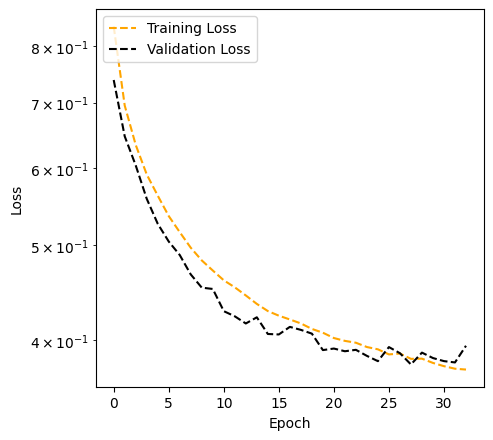

In [ ]:


##Lets see the training process metrics
def plot_results(history):
  f,ax=plt.subplots(figsize=(5,5),dpi=100)
  epochs=history.epoch
  metric_tr=history.history.get('loss')
  metric_val=history.history.get('val_loss')
  plt.semilogy(epochs, metric_tr, color='orange', label='Training Loss',linestyle='--')
  plt.semilogy(epochs, metric_val, color='black', label='Validation Loss',linestyle='--')
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  plt.legend(loc="upper left")
plot_results(history=history)  

In [ ]:
##Function to compute metrics 
from sklearn.metrics import cohen_kappa_score,accuracy_score,f1_score,precision_score,recall_score,make_scorer
def metrics(real,pred):
  kappa=cohen_kappa_score(real,pred)
  acc=accuracy_score(real,pred)
  f1=f1_score(real,pred)
  prec=precision_score(real,pred)
  recall=recall_score(real,pred)

  print (f" Accuracy:{acc:.4f} \n Precision: {prec:.4f} \n Recall: {recall:.4f} \n Kappa: {kappa:.4f} \n F1-Score: {f1:.4f} ")


In [ ]:
##check performance on validation(test) set
y_pred=model.predict(X_train)
y_pred_test=model.predict(X_test)

print("="*5+"TRAINING"+"="*5)
metrics(Y_train,np.round(y_pred))
print("="*5+"TESTING"+"="*5)
metrics(Y_test,np.round(y_pred_test))

=====TRAINING=====
 Accuracy:0.8989 
 Precision: 0.9377 
 Recall: 0.7390 
 Kappa: 0.7567 
 F1-Score: 0.8266 
=====TESTING=====
 Accuracy:0.8735 
 Precision: 0.8885 
 Recall: 0.6996 
 Kappa: 0.6953 
 F1-Score: 0.7828 


## Predict on new data

lets create and end-to-end pipeline to predict the polarity out of a raw text

In [ ]:
str_test="I dont like this movie"

def predict_str_data(new_text):
  new_text=remove_special(new_text)
  vect=vectorizer(np.array([new_text])).numpy()
  score=model.predict(vect)[0]
  return (
      {'text':new_text,'score':score[0],'label': 'pos' if score>0.5 else 'neg'}
      )

predict_str_data(str_test)

{'label': 'neg', 'score': 0.15315273, 'text': 'i dont like this movie'}

In [ ]:
###end to end model
from keras.models import load_model
model=load_model('sentiment_cnn.h5')

In [ ]:
model.summary()

Model: "predictor_polarity"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_24 (Embedding)     (None, None, 100)         100200    
_________________________________________________________________
conv1d_31 (Conv1D)           (None, None, 32)          16032     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 32)                0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)         

## Further Work

Fit the model using all available data, once we've defined all the parameters for every layer in our CNN model. For now lets just create an end to end model. (text to score)

In [ ]:
text_input =Input(shape=(1,),dtype=tf.string)
x=vectorizer(text_input)
x=model(x)
model2=Model(text_input,x,name="end-to-end-sentiment")


In [66]:
##lets use previous callbacks and metrics
patience_call=5
metric=tf.keras.metrics.AUC()
y_glob=reviews.label.values.astype('int64')
cb_f = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience_call,restore_best_weights=True) #set the best weights found at scoring on validation set
opt = Adam(learning_rate=1e-4)
model2.compile(
    loss="binary_crossentropy", optimizer=opt, metrics=[metric]
)
check = tf.keras.callbacks.ModelCheckpoint('/content',
                                           monitor='loss', 
                                           save_best_only=True,
                                           mode='max',
                                           patience=patience_call)

history2=model2.fit(x=reviews.text,y=y_glob, batch_size=50, epochs=30,callbacks=[cb_f,check],class_weight=class_weight)

Epoch 1/30
755/755 [==============================] - 49s 64ms/step - loss: 0.3892 - auc_5: 0.8954
INFO:tensorflow:Assets written to: /content/assets
Epoch 2/30
755/755 [==============================] - 47s 62ms/step - loss: 0.3877 - auc_5: 0.8963
Epoch 3/30
755/755 [==============================] - 45s 60ms/step - loss: 0.3845 - auc_5: 0.8982
Epoch 4/30
755/755 [==============================] - 45s 60ms/step - loss: 0.3843 - auc_5: 0.8985
Epoch 5/30
755/755 [==============================] - 46s 61ms/step - loss: 0.3808 - auc_5: 0.9017
Epoch 6/30
755/755 [==============================] - 47s 62ms/step - loss: 0.3780 - auc_5: 0.9022
Epoch 7/30
755/755 [==============================] - 46s 60ms/step - loss: 0.3782 - auc_5: 0.9020
Epoch 8/30
755/755 [==============================] - 46s 61ms/step - loss: 0.3752 - auc_5: 0.9037
Epoch 9/30
755/755 [==============================] - 46s 61ms/step - loss: 0.3739 - auc_5: 0.9047
Epoch 10/30
755/755 [==============================] - 46s

In [67]:
model2.predict(["i dont like this movie"])

array([[0.16742826]], dtype=float32)

## Save Model for later usage/testing

In [70]:
model2.save('/content/models/sentiment_cnn_new',save_format='tf')

INFO:tensorflow:Assets written to: /content/models/sentiment_cnn_new/assets
